### Experiment1_Plotting distances and angles
Author : @leopauly | cnlp@leeds.ac.uk <br>
Description : Studying the feature vectors in the feature space

In [1]:
import os
from six.moves import xrange  # pylint: disable=redefined-builtin
import PIL.Image as Image
import random
import numpy as np
import cv2
import time
import math
import matplotlib.pyplot as plt
from keras.applications.vgg16 import preprocess_input

# Custom scripts
import lscript as lsp
import modelling as md

Using TensorFlow backend.


In [2]:
height=112 
width=112 
channel=3
crop_size=112

cluster_length=16
feature_size=4608 #8192   #16384  #487
nb_classes=2

batch_size=32
memory_batch_size_train=266
memory_batch_size_test=170
next_batch_start=0
sample_batch_size=10
mean=[123.68, 116.779, 103.939] 

In [3]:
base_model=md.get_vgg16_imagenet(summary=True,include_fc=False)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [4]:
def dotproduct(v1, v2):
  return sum((a*b) for a, b in zip(v1, v2))

def length(v):
  return math.sqrt(dotproduct(v, v))

def angle(v1, v2):
    cos_val=dotproduct(v1, v2) / (length(v1) * length(v2))
    cos_val=float(cos_val)
    cos_val=clean_cos(cos_val)
    angle_in_rad=math.acos(cos_val)
    #print(angle_in_rad)
    return angle_in_rad

def clean_cos(cos_val):
    return min(1,max(cos_val,-1))

In [5]:
def get_compress_frames_data(filename, num_frames_per_clip=16):
  ''' Given a directory containing extracted frames, return a video clip of
  (num_frames_per_clip) consecutive frames as a list of np arrays '''
  ret_arr = []
  for parent, dirnames, filenames in os.walk(filename):

    filenames = sorted(filenames)
    jump=math.floor((len(filenames)/num_frames_per_clip))
    loop=0
    for i in range(0,len(filenames),jump):
      if (loop>15):
        break
      if (filenames[i].endswith('.png')):
        image_name = str(filename) + '/' + str(filenames[i])
        img = Image.open(image_name)
        img_data = np.array(img)
        ret_arr.append(img_data)
        loop=loop+1
  ret_arr=np.array(ret_arr)
  #ret_arr=ret_arr/255
  return np.array(ret_arr)

In [6]:
## Extraction of features - baseline
def extract_baseline_video_features(vid):
    
    sum_val=0
    for i in range(cluster_length):
        frame_=vid[i]
        
        #frame_=frame_.reshape(-1,height,width,channel)
        #frame= preprocess_input(frame_) # prepare the image for the VGG model
        
        frame=preprocess(frame_,mean)
        frame=frame.reshape(-1,height,width,channel)
        
        temp_val=base_model.predict(frame)
        temp_val=temp_val.reshape(feature_size)
        #print('temp_val',temp_val.shape)
        sum_val=sum_val+temp_val
        #print('sum_val',sum_val.shape)
    features=sum_val/cluster_length
    #print('feature from one video.shape',features.shape)
    return features

In [7]:
def preprocess(im,mean):
        im = np.float32(im)
        im[:,:,2] -= 103.939
        im[:,:,1] -= 116.779
        im[:,:,0] -= 123.68
        im = im[:, :, ::-1]  # change to BGR
        return im

In [8]:
def dist_angle_calc(directory1,directory2):
    baseline_dist=[]
    baseline_angle=[]
    activity_dist=[]
    activitynet_angle=[]
    
    subfolders1=os.listdir(directory1)
    subfolders1=sorted(subfolders1)
    subfolders2=os.listdir(directory2)
    subfolders2=sorted(subfolders2)
    
    for subfolder1_ in subfolders1:
        data1=get_compress_frames_data(directory1+'/'+subfolder1_)
        
        for subfolder2_ in subfolders2:
            data2=get_compress_frames_data(directory2+'/'+subfolder2_)
            
            dist_base_=np.linalg.norm(extract_baseline_video_features(data1)-extract_baseline_video_features(data2))
            #dist_act_=activity_model(data1)-activity_model(data2)
            
            baseline_dist.append(dist_base_)
            #activity_dist.append(dist_act_)
            
            angle_base_=angle(extract_baseline_video_features(data1),extract_baseline_video_features(data2))
            #angle_act_=activity_model(data1)-activity_model(data2)
            
            baseline_angle.append(angle_base_)
            #activity_angle.append(dist_angle_)
    
    return baseline_dist,baseline_angle#,activitynet_dist

In [9]:
## Getting feature space distances for values for similar activity videos
baseline_plot_sim=[]
baseline_plot_angle_sim=[]
activitynet_plot_sim=[]


baseline_dist_,baseline_angle_=dist_angle_calc('/nobackup/leopauly/leeds_reordered/hit','/nobackup/leopauly/leeds_reordered/hit')
#print(baseline_dist_)
baseline_plot_sim.append([baseline_dist_])
baseline_plot_angle_sim.append([baseline_angle_])

baseline_dist_,baseline_angle_=dist_angle_calc('/nobackup/leopauly/leeds_reordered/push','/nobackup/leopauly/leeds_reordered/push')
baseline_plot_sim.append([baseline_dist_])
baseline_plot_angle_sim.append([baseline_angle_])

baseline_dist_,baseline_angle_=dist_angle_calc('/nobackup/leopauly/leeds_reordered/reach','/nobackup/leopauly/leeds_reordered/reach')
baseline_plot_sim.append([baseline_dist_])
baseline_plot_angle_sim.append([baseline_angle_])

baseline_dist_,baseline_angle_=dist_angle_calc('/nobackup/leopauly/leeds_reordered/pour','/nobackup/leopauly/leeds_reordered/pour')
baseline_plot_sim.append([baseline_dist_])
baseline_plot_angle_sim.append([baseline_angle_])


In [10]:
baseline_plot_sim=np.array(baseline_plot_sim)
baseline_plot_sim=baseline_plot_sim.reshape(100)
print(baseline_plot_sim)
print(baseline_plot_sim.shape)

[   0.          637.78582764  543.45587158  592.88702393  587.01812744
  637.78582764    0.          621.62237549  678.21099854  535.38323975
  543.45587158  621.62237549    0.          537.20367432  628.75976562
  592.88702393  678.21099854  537.20367432    0.          558.30682373
  587.01812744  535.38323975  628.75976562  558.30682373    0.            0.
  381.4850769   496.70892334  542.706604    494.20098877  381.4850769     0.
  455.20739746  467.72802734  522.35308838  496.70892334  455.20739746
    0.          406.61410522  348.80639648  542.706604    467.72802734
  406.61410522    0.          420.36779785  494.20098877  522.35308838
  348.80639648  420.36779785    0.            0.          195.20582581
  580.13421631  534.48419189  481.86697388  195.20582581    0.
  602.97833252  575.16784668  537.32507324  580.13421631  602.97833252
    0.          250.13162231  510.70056152  534.48419189  575.16784668
  250.13162231    0.          476.49639893  481.86697388  537.32507324
  

In [11]:
baseline_plot_angle_sim=np.array(baseline_plot_angle_sim)
baseline_plot_angle_sim=baseline_plot_angle_sim.reshape(100)
print(baseline_plot_angle_sim)
print(baseline_plot_angle_sim.shape)

[  0.00000000e+00   6.75423325e-01   5.80979061e-01   6.38385244e-01
   6.31430102e-01   6.75423325e-01   0.00000000e+00   6.67208937e-01
   7.34021235e-01   5.73460925e-01   5.80979061e-01   6.67208937e-01
   0.00000000e+00   5.86742970e-01   6.90087801e-01   6.38385244e-01
   7.34021235e-01   5.86742970e-01   0.00000000e+00   6.13214319e-01
   6.31430102e-01   5.73460925e-01   6.90087801e-01   6.13214319e-01
   0.00000000e+00   0.00000000e+00   4.95502693e-01   6.30054448e-01
   6.58735778e-01   6.41444079e-01   4.95502693e-01   0.00000000e+00
   5.58996256e-01   5.52504933e-01   6.54258700e-01   6.30054448e-01
   5.58996256e-01   0.00000000e+00   4.72163178e-01   4.21668970e-01
   6.58735778e-01   5.52504933e-01   4.72163178e-01   0.00000000e+00
   4.91480601e-01   6.41444079e-01   6.54258700e-01   4.21668970e-01
   4.91480601e-01   0.00000000e+00   0.00000000e+00   2.44582021e-01
   7.34200604e-01   6.69136704e-01   6.68493664e-01   2.44582021e-01
   0.00000000e+00   7.49641257e-01

In [12]:
## Getting feature space distances for values for dissimilar activity videos
baseline_plot_dis=[]
baseline_plot_angle_dis=[]
activitynet_plot_dis=[]


baseline_dist_,baseline_angle_=dist_angle_calc('/nobackup/leopauly/leeds_reordered/hit','/nobackup/leopauly/leeds_reordered/push')
#print(baseline_dist_)
baseline_plot_dis.append([baseline_dist_])
baseline_plot_angle_dis.append([baseline_angle_])

baseline_dist_,baseline_angle_=dist_angle_calc('/nobackup/leopauly/leeds_reordered/hit','/nobackup/leopauly/leeds_reordered/reach')
baseline_plot_dis.append([baseline_dist_])
baseline_plot_angle_dis.append([baseline_angle_])

baseline_dist_,baseline_angle_=dist_angle_calc('/nobackup/leopauly/leeds_reordered/push','/nobackup/leopauly/leeds_reordered/reach')
baseline_plot_dis.append([baseline_dist_])
baseline_plot_angle_dis.append([baseline_angle_])

baseline_dist_,baseline_angle_=dist_angle_calc('/nobackup/leopauly/leeds_reordered/pour','/nobackup/leopauly/leeds_reordered/reach')
baseline_plot_dis.append([baseline_dist_])
baseline_plot_angle_dis.append([baseline_angle_])

baseline_dist_,baseline_angle_=dist_angle_calc('/nobackup/leopauly/leeds_reordered/pour','/nobackup/leopauly/leeds_reordered/hit')
baseline_plot_dis.append([baseline_dist_])
baseline_plot_angle_dis.append([baseline_angle_])

baseline_dist_,baseline_angle_=dist_angle_calc('/nobackup/leopauly/leeds_reordered/pour','/nobackup/leopauly/leeds_reordered/push')
baseline_plot_dis.append([baseline_dist_])
baseline_plot_angle_dis.append([baseline_angle_])

In [13]:
baseline_plot_dis=np.array(baseline_plot_dis)
baseline_plot_dis=baseline_plot_dis.reshape(150)
print(baseline_plot_dis)
print(baseline_plot_dis.shape)

[  686.44921875   664.56994629   685.40618896   597.86151123   686.90783691
   715.42468262   754.35211182   740.55340576   695.82696533   715.82440186
   573.31719971   506.77145386   507.66305542   364.96469116   523.82623291
   612.66674805   550.14599609   623.30828857   597.06134033   659.89074707
   644.99066162   643.20129395   622.15472412   656.33227539   659.43804932
   630.21826172   655.84570312   720.15789795   701.76312256   733.16558838
   702.98388672   720.85803223   786.39880371   772.50091553   763.94885254
   658.95617676   681.17852783   675.2543335    671.81451416   698.29290771
   577.13031006   605.52050781   596.4473877    576.9107666    599.91943359
   596.6262207    645.46453857   727.18328857   694.43133545   711.45501709
   447.2074585    478.47164917   620.30480957   597.46246338   480.78967285
   520.45068359   546.69580078   566.82678223   553.70318604   544.5057373
   621.66333008   672.60571289   650.43676758   632.30212402   630.20166016
   658.981201

In [14]:
baseline_plot_angle_dis=np.array(baseline_plot_angle_dis)
baseline_plot_angle_dis=baseline_plot_angle_dis.reshape(150)
print(baseline_plot_angle_dis)
print(baseline_plot_angle_dis.shape)

[ 0.79377254  0.75204167  0.7687395   0.65390139  0.77563794  0.83356715
  0.86511456  0.83534749  0.76709059  0.8106458   0.66036339  0.57360705
  0.57110691  0.40061415  0.59306235  0.72449947  0.63355386  0.71560174
  0.67079441  0.76653427  0.76909527  0.7500197   0.71341535  0.74003072
  0.76510109  0.71321643  0.74091442  0.81146649  0.78720244  0.86196793
  0.80802308  0.82212301  0.89245111  0.87297804  0.90523672  0.77368528
  0.79295131  0.77423148  0.76809826  0.8397576   0.6725963   0.703045
  0.68311008  0.65797775  0.70631843  0.69722125  0.7527057   0.8433674
  0.80043307  0.86636526  0.61453041  0.63279989  0.8075418   0.76968474
  0.70163276  0.67636154  0.69496696  0.70276681  0.68261664  0.73155305
  0.78999061  0.84118448  0.79359445  0.76738034  0.82482651  0.80911843
  0.83731339  0.74995525  0.75802983  0.84779099  0.78208486  0.8312131
  0.85745279  0.82390287  0.81001256  1.28403908  1.28837188  1.28337576
  1.28140278  1.3588186   1.3580016   1.3707769   1.373

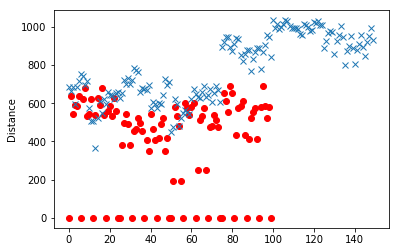

In [15]:
## Plotting
plt.plot(baseline_plot_sim,'ro')
plt.plot(baseline_plot_dis,'x')
plt.ylabel('Distance')
plt.show()

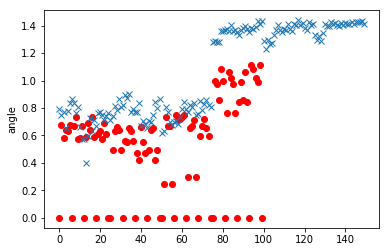

In [16]:
## Plotting
plt.plot(baseline_plot_angle_sim,'ro')
plt.plot(baseline_plot_angle_dis,'x')
plt.ylabel('angle')
plt.show()